In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import csv

import gensim
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import spacy
import logging, warnings

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tc','acne', 'type', 'ca', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'rt', 'medicine', 'heal', 'healing', 'nature'])

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
# import data
df = pd.read_csv('input_data/clean_unique_tweet.csv')
print(df.shape)
df.head()

In [ ]:
df.columns

In [78]:
# text cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# convert to list
data = df.cleantext.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['thingsdaily', 'im', 'grateful', 'forfull', 'moonspring', 'equinoxthe', 'seasons']]


In [79]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

C:\Users\shawo\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [80]:
data_ready

[['thingsdaily', 'grateful', 'forfull', 'moonspr', 'season'],
 ['thingsdaily',
  'look',
  'forward',
  'breakfast',
  'dad',
  'spray',
  'painting',
  'crochet'],
 ['chiropractic', 'chiro', 'bless', 'chiropractic', 'wellness'],
 ['abhyangam',
  'massage',
  'mode',
  'treatment',
  'read',
  'crucial',
  'tcourxxzgll'],
 ['pimple',
  'breakout',
  'guide',
  'different',
  'removal',
  'strategy',
  'natural',
  'treatment'],
 ['tired', 'deal', 'cbd', 'hemp', 'oil', 'answer', 'look', 'benefit'],
 ['tired', 'deal', 'cbd', 'hemp', 'oil', 'answer', 'look', 'benefit'],
 ['look',
  'natural',
  'solution',
  'ayurveda',
  'old',
  'tradition',
  'health',
  'wellness',
  'world'],
 ['pimple',
  'breakout',
  'guide',
  'different',
  'removal',
  'strategy',
  'natural',
  'treatment'],
 ['look',
  'natural',
  'solution',
  'ayurveda',
  'old',
  'tradition',
  'health',
  'wellness',
  'world'],
 ['chinese', 'depressionmood', 'elevation', 'heregreenwitch', 'botan'],
 ['brief',
  'course

In [89]:
# create dictionary
id2word = corpora.Dictionary(data_ready)

# create corpus for term-tweet frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.034*"cannabis" + 0.030*"new" + 0.029*"chiropractic" + 0.023*"holistic" + '
  '0.023*"call" + 0.016*"team" + 0.016*"space" + 0.015*"sit" + 0.014*"late" + '
  '0.012*"accord"'),
 (1,
  '0.091*"natural" + 0.018*"stress" + 0.018*"selfcare" + 0.017*"relax" + '
  '0.017*"learn" + 0.016*"plant" + 0.015*"herbal" + 0.014*"join" + '
  '0.013*"wellbe" + 0.013*"reminder"'),
 (2,
  '0.038*"treatment" + 0.024*"start" + 0.020*"age" + 0.019*"april" + '
  '0.019*"student" + 0.019*"vegan" + 0.017*"plantmedicine" + 0.016*"body" + '
  '0.015*"pm" + 0.015*"recipe"'),
 (3,
  '0.071*"health" + 0.053*"ayurveda" + 0.050*"benefit" + 0.032*"day" + '
  '0.027*"love" + 0.022*"stimulate" + 0.021*"remedy" + 0.020*"create" + '
  '0.017*"healthy" + 0.016*"cost"'),
 (4,
  '0.035*"help" + 0.029*"bright" + 0.026*"acupuncture" + 0.023*"cure" + '
  '0.018*"pain" + 0.017*"mediatation" + 0.014*"hard" + 0.013*"prevent" + '
  '0.013*"clinic" + 0.011*"purple"'),
 (5,
  '0.099*"taichi" + 0.023*"continue" + 0.023*"great

In [90]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.4728,"yoga, wellness, happy, holistichealth, green, world, cbd, time, instructor, reiki","[thingsdaily, grateful, forfull, moonspr, season]"
1,1,3.0,0.6791,"health, ayurveda, benefit, day, love, stimulate, remedy, create, healthy, cost","[thingsdaily, look, forward, breakfast, dad, spray, painting, crochet]"
2,2,0.0,0.4346,"cannabis, new, chiropractic, holistic, call, team, space, sit, late, accord","[chiropractic, chiro, bless, chiropractic, wellness]"
3,3,2.0,0.5804,"treatment, start, age, april, student, vegan, plantmedicine, body, pm, recipe","[abhyangam, massage, mode, treatment, read, crucial, tcourxxzgll]"
4,4,1.0,0.3795,"natural, stress, selfcare, relax, learn, plant, herbal, join, wellbe, reminder","[pimple, breakout, guide, different, removal, strategy, natural, treatment]"
5,5,6.0,0.6571,"yoga, wellness, happy, holistichealth, green, world, cbd, time, instructor, reiki","[tired, deal, cbd, hemp, oil, answer, look, benefit]"
6,6,6.0,0.6571,"yoga, wellness, happy, holistichealth, green, world, cbd, time, instructor, reiki","[tired, deal, cbd, hemp, oil, answer, look, benefit]"
7,7,3.0,0.3100,"health, ayurveda, benefit, day, love, stimulate, remedy, create, healthy, cost","[look, natural, solution, ayurveda, old, tradition, health, wellness, world]"
8,8,1.0,0.3798,"natural, stress, selfcare, relax, learn, plant, herbal, join, wellbe, reminder","[pimple, breakout, guide, different, removal, strategy, natural, treatment]"
9,9,3.0,0.3100,"health, ayurveda, benefit, day, love, stimulate, remedy, create, healthy, cost","[look, natural, solution, ayurveda, old, tradition, health, wellness, world]"


In [91]:
# display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9250,"cannabis, new, chiropractic, holistic, call, team, space, sit, late, accord","[build, new, front, desk, scratch, leave, move, guy, new, space, stain]"
1,1.0,0.9182,"natural, stress, selfcare, relax, learn, plant, herbal, join, wellbe, reminder","[emphasize, enough, usefulness, gentle, power, ignatia, amara, specie, grief, sadne]"
2,2.0,0.9250,"treatment, start, age, april, student, vegan, plantmedicine, body, pm, recipe","[mongolian, ruxiani, treatment, estrogeninduc, mammary, gland, hyperplasia, rat, relate, tctp, r..."
3,3.0,0.9357,"health, ayurveda, benefit, day, love, stimulate, remedy, create, healthy, cost","[judy, mayo, sid, aaron, georgetown, texas, naming, mjff, beneficiary, ira, retirement, fund, na..."
4,4.0,0.9250,"help, bright, acupuncture, cure, pain, mediatation, hard, prevent, clinic, purple","[panax, ginseng, inhibit, metabolism, diester, alkaloid, downregulat, cypa, enzyme, activity, pr..."
5,5.0,0.9357,"taichi, continue, great, keep, year, sign, alternative, end, chiropractor, read","[shipbruary, summer, date, yamaichi, taiyama, taichixyamato, digimon, digimontri, taichi, yamato..."
6,6.0,0.9182,"yoga, wellness, happy, holistichealth, green, world, cbd, time, instructor, reiki","[cbdfact, cbd, online, storelink, bio, cbdoil, cbd, cbddeutschland, cbdgesundheit, cbdflower]"
7,7.0,0.9357,"give, night, alexander, laser, care, enjoy, homeopathy, food, therapy, really","[frangipani, simbolizan, refugio, proteccin, los, aceite, esta, flor, tienen, influencia, tranqu..."
8,8.0,0.9182,"mushroom, qigong, today, hand, free, push, sunday, holisticheal, home, together","[suffer, lumbego, consumption, melancholia, grip, ague, dropsy, chalkstone, tired, listless]"
9,9.0,0.9250,"youtube, clip, train, martialart, channel, meditation, skin, channeltaolu, find, study","[mindvalley, academy, founder, vishen, thetapetra, founder, thalia, alexiou, petra, terzi, ltlove]"


In [92]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# plot
plt.figure(figsize=(16,7), dpi=200)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 30), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,30,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

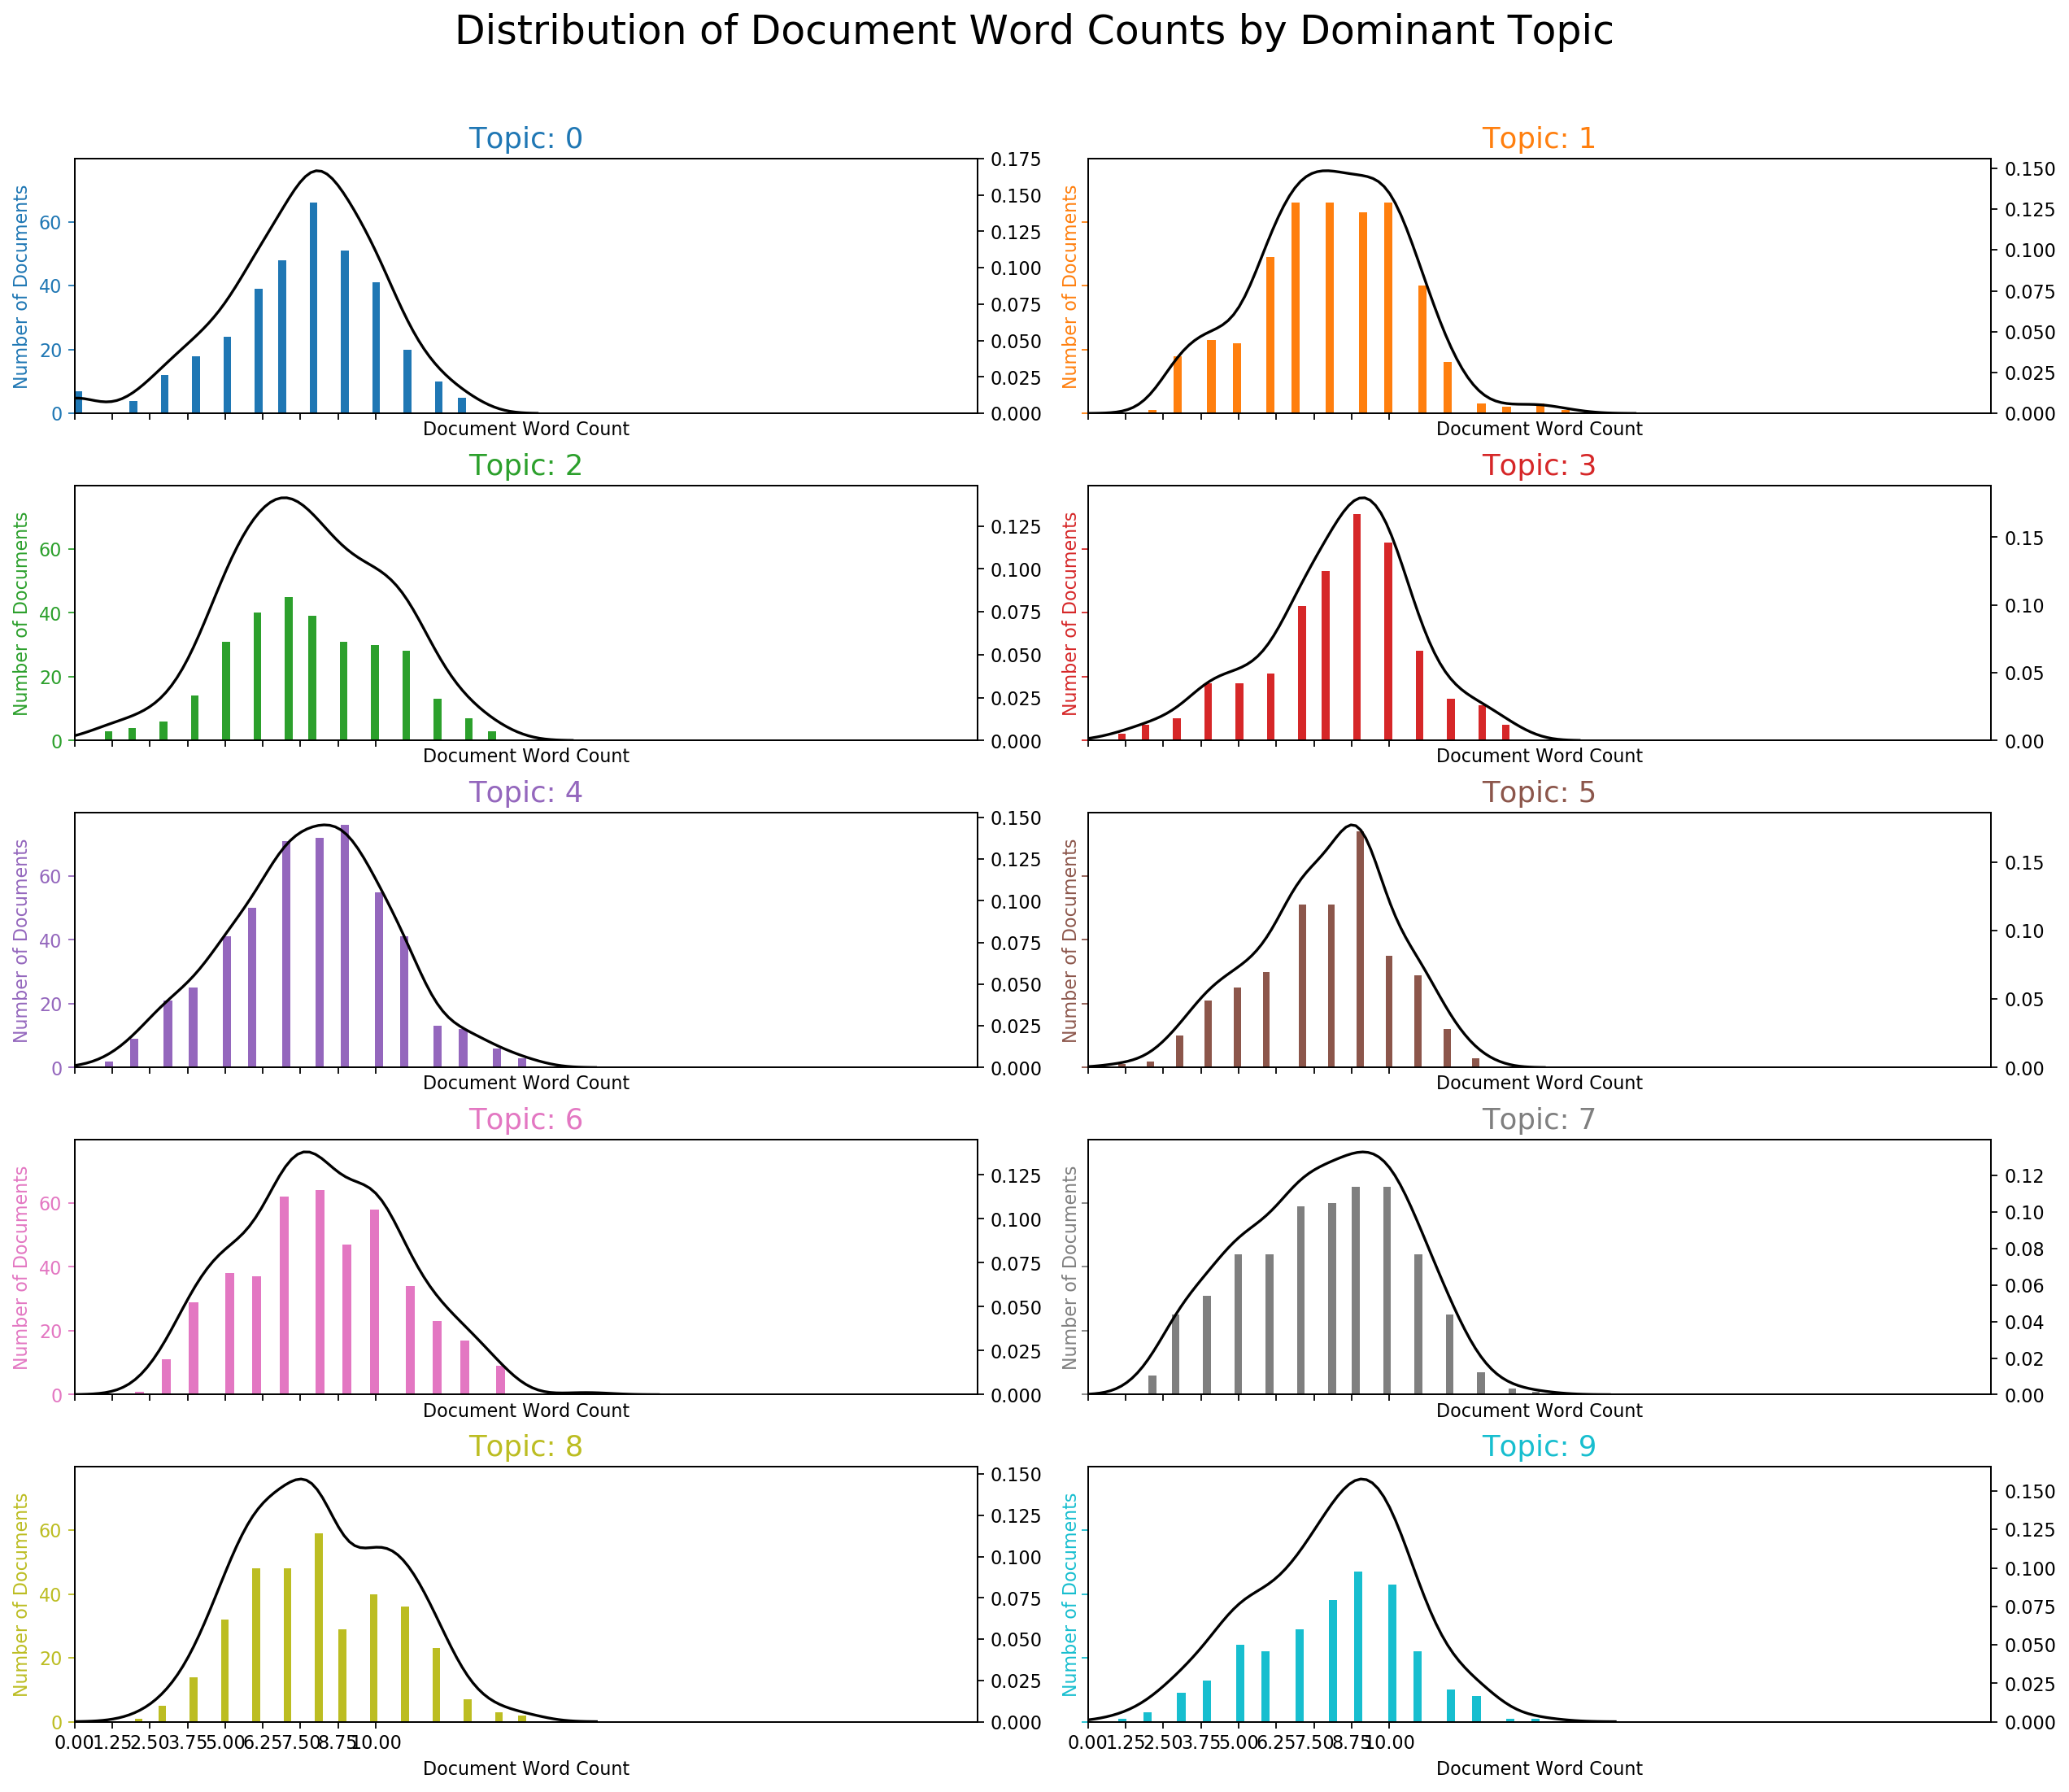

In [93]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,10,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

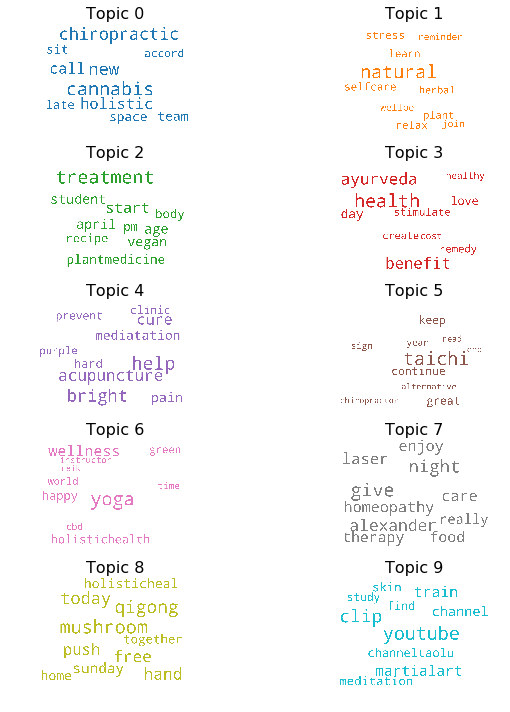

In [95]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

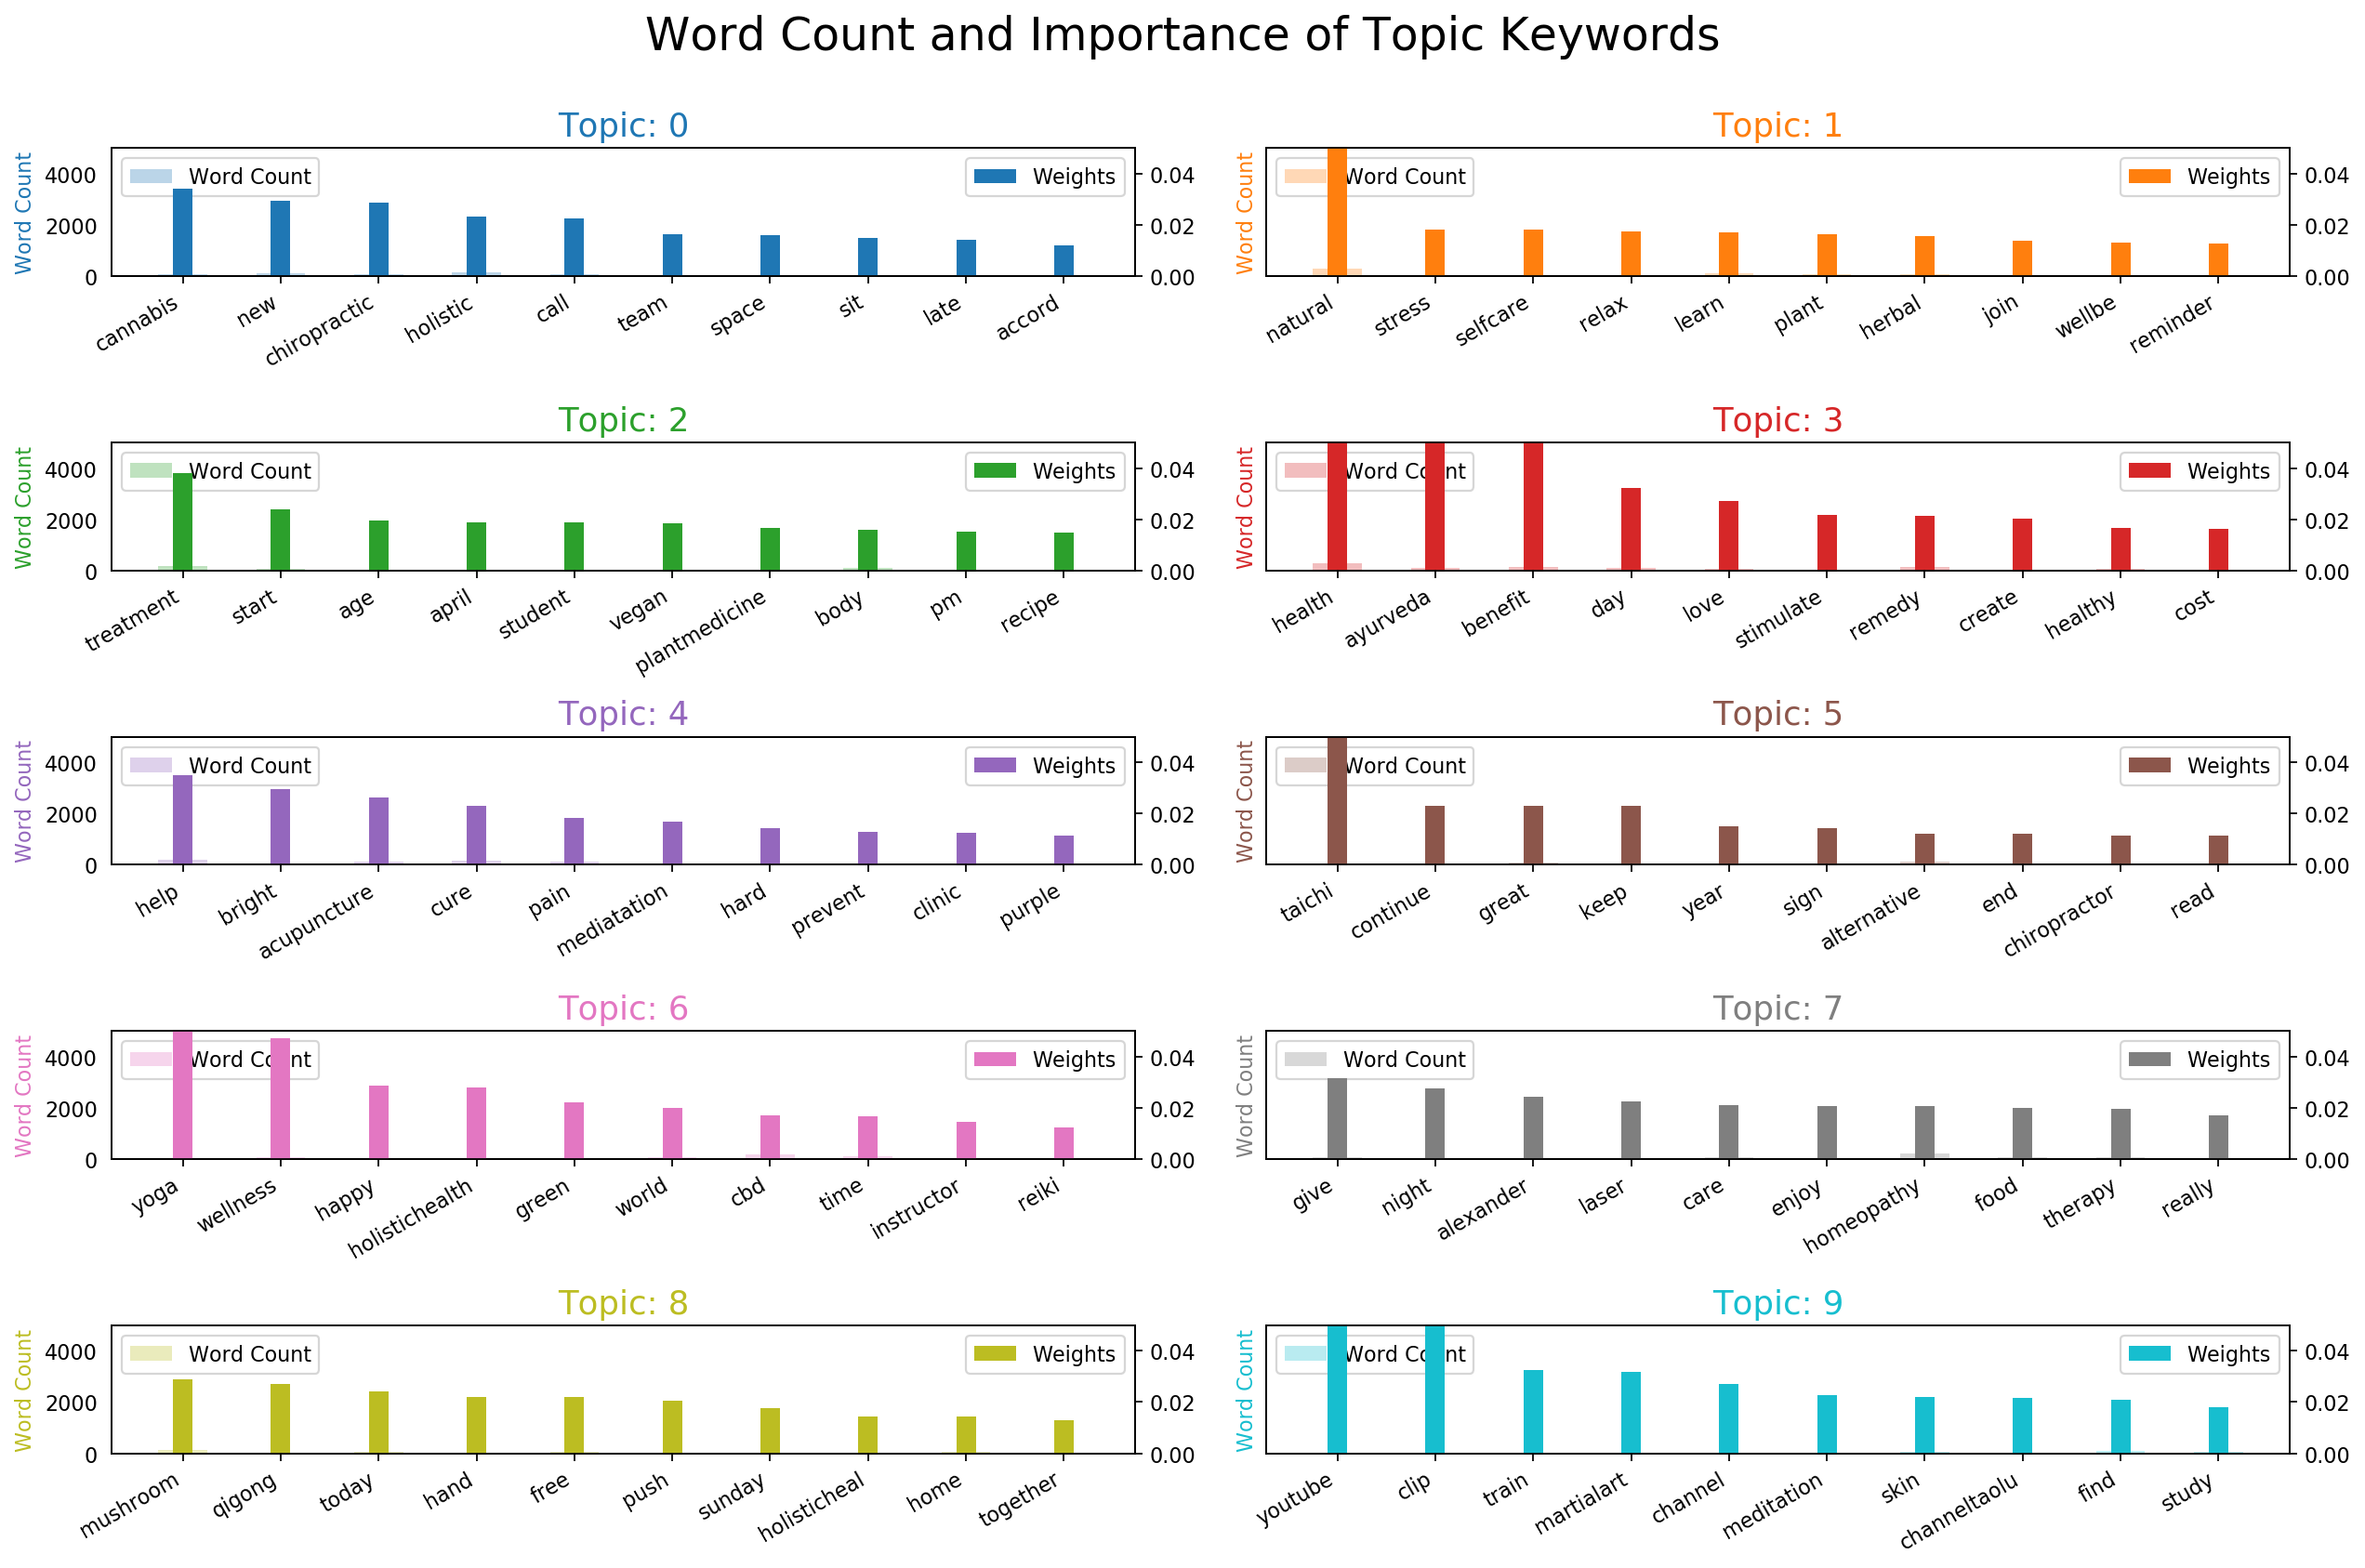

In [97]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

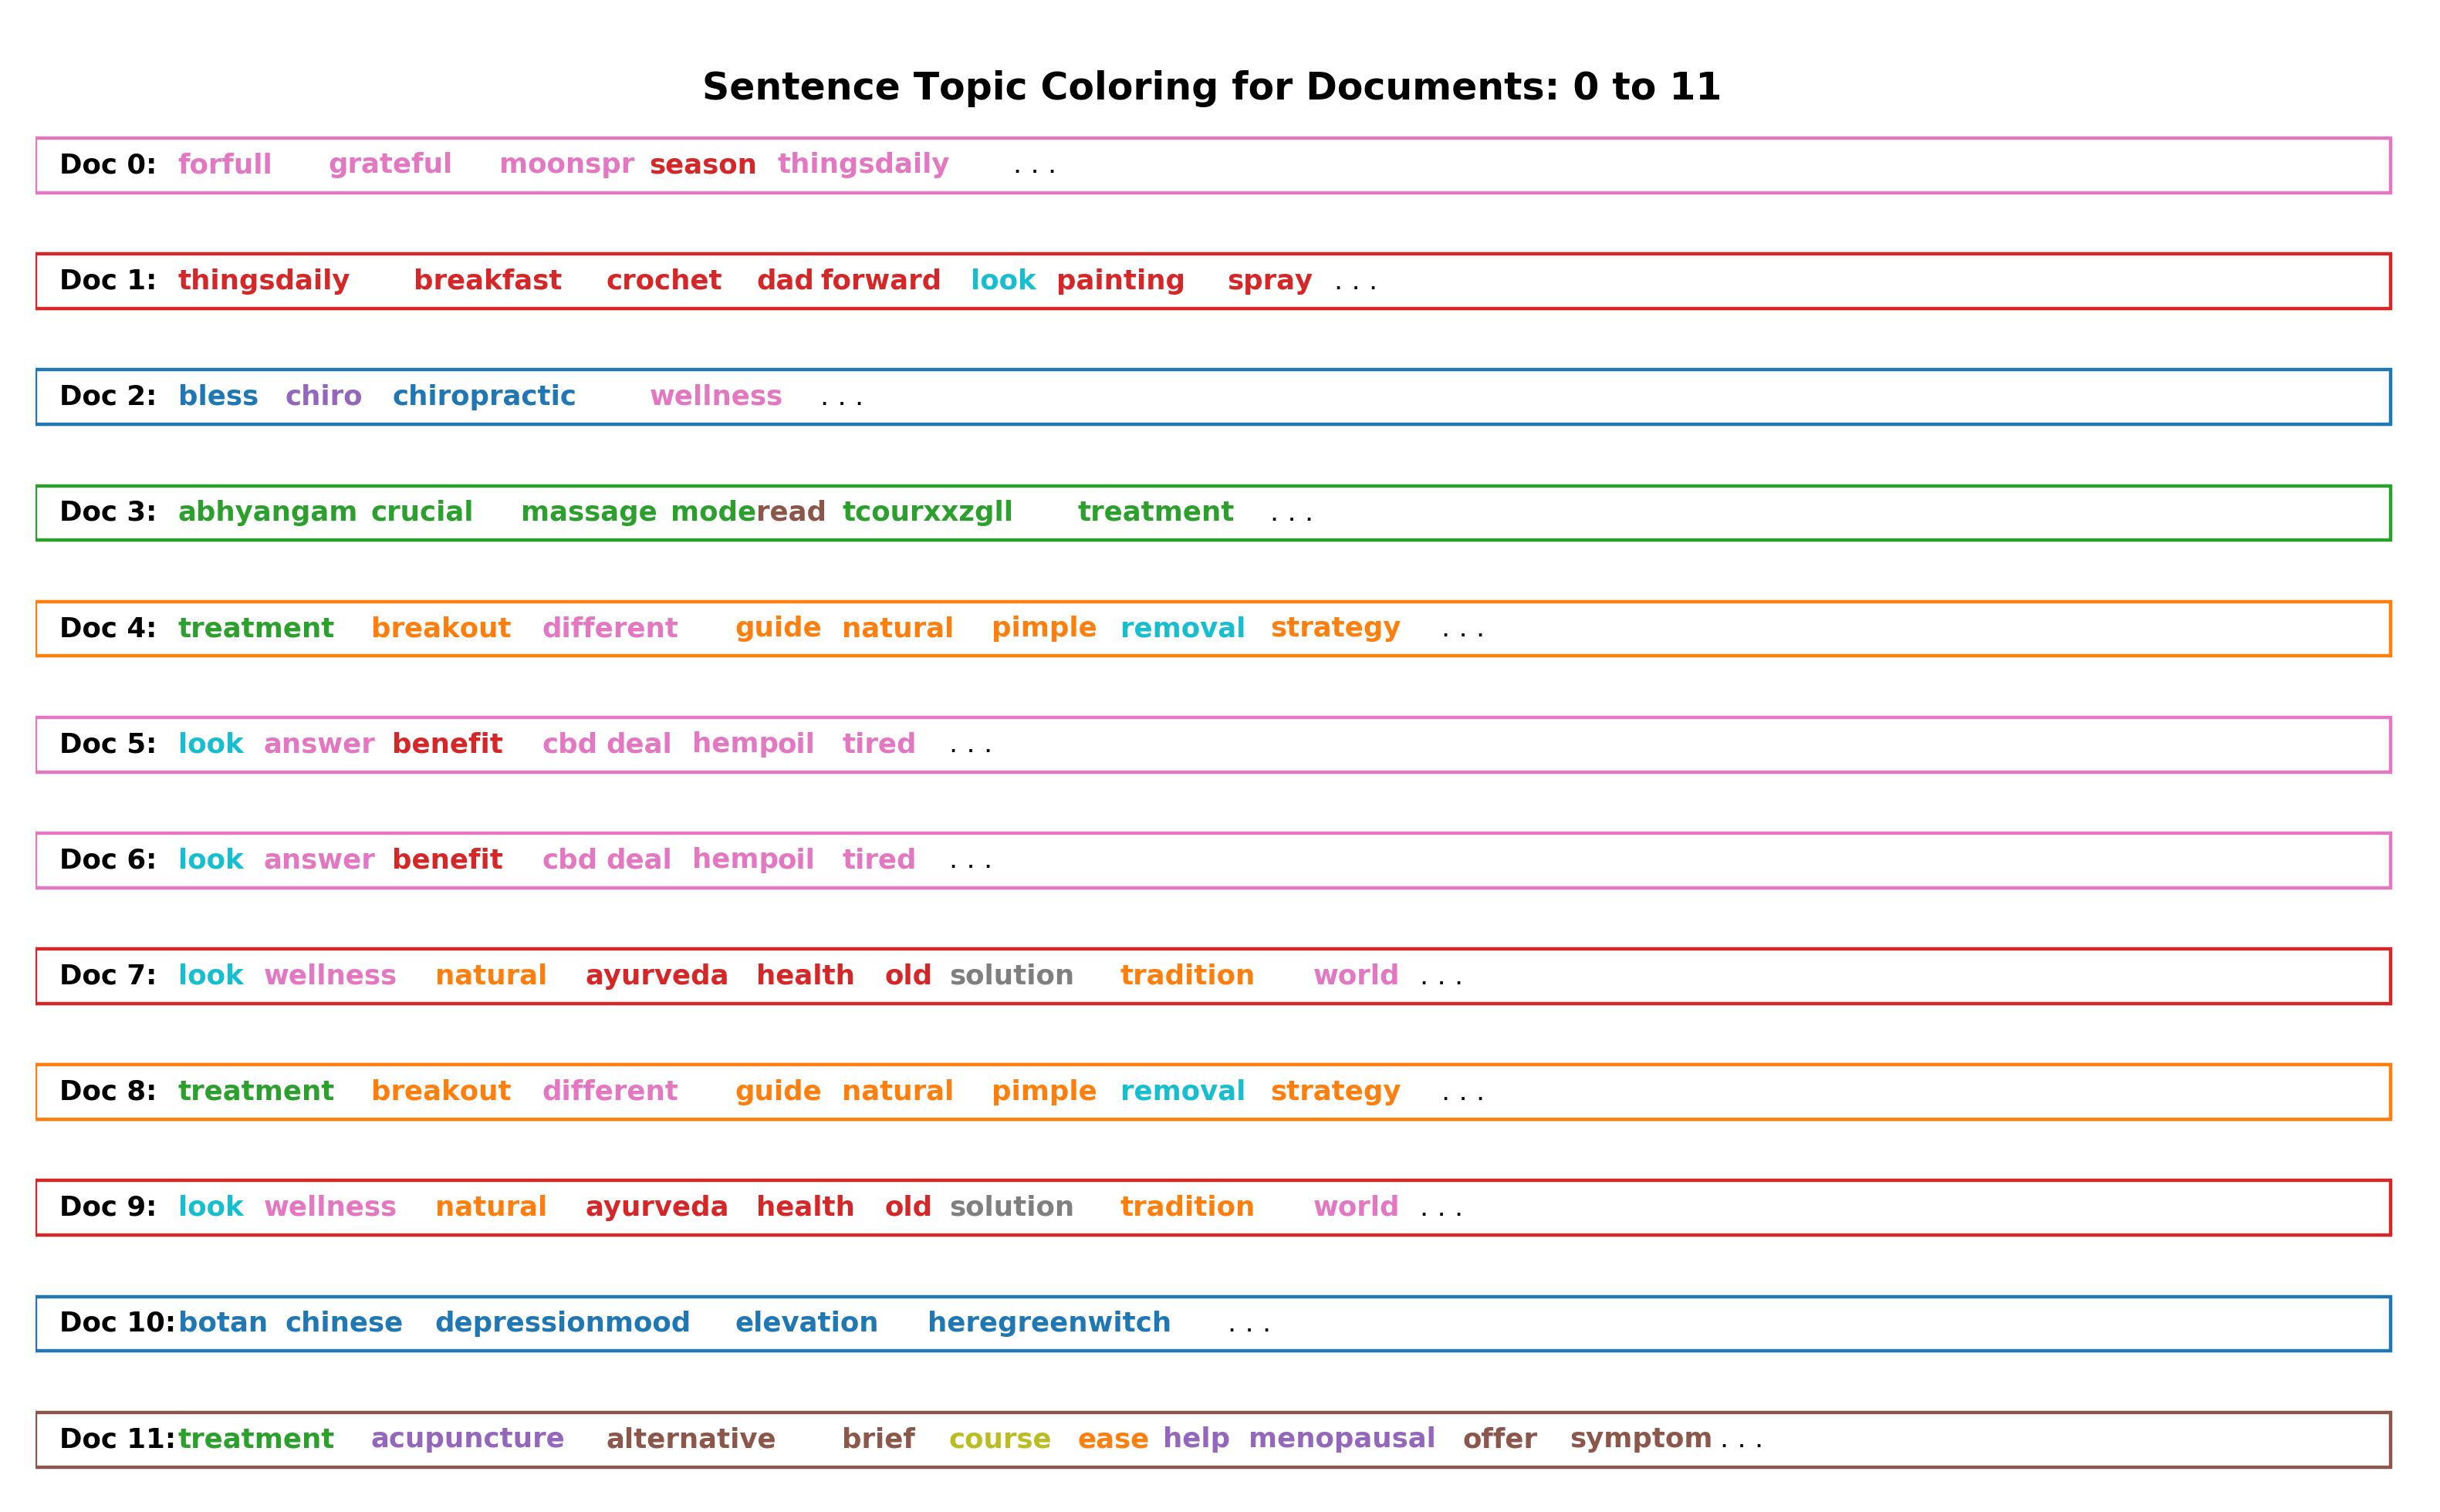

In [98]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [99]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

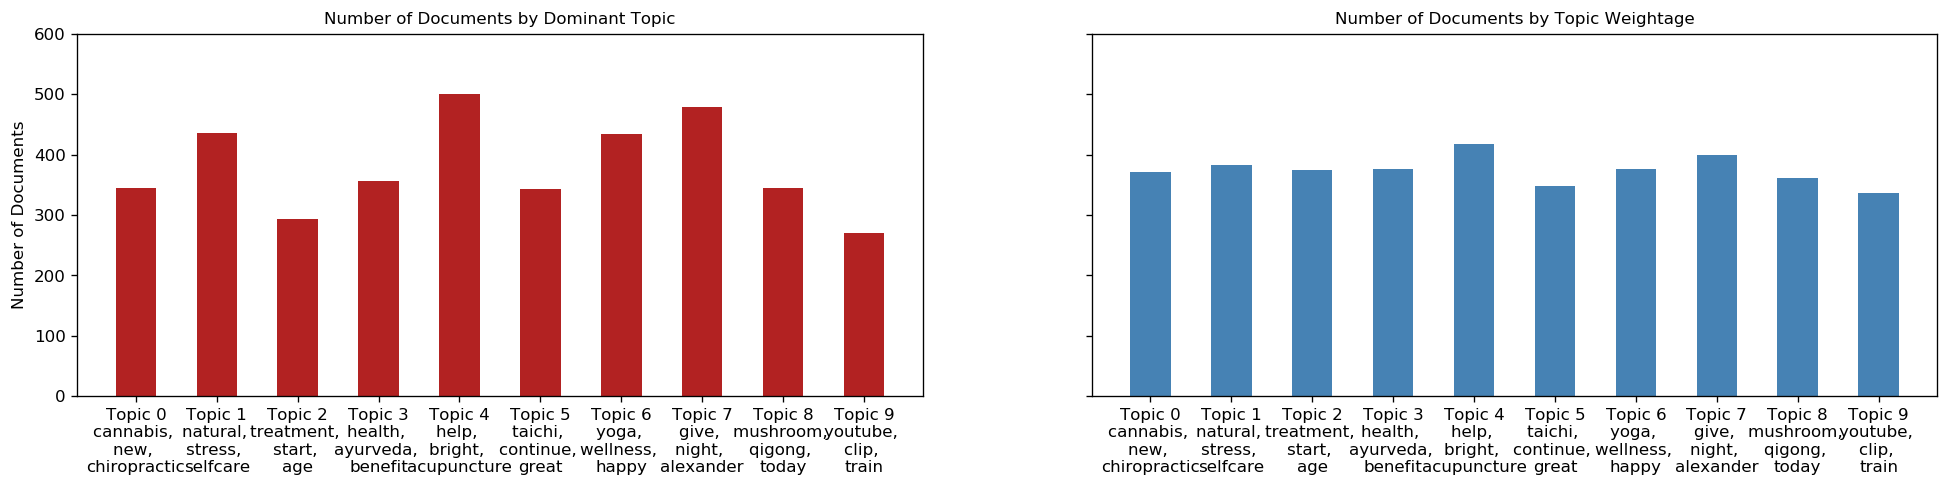

In [106]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 600)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [107]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2926 samples in 0.007s...
[t-SNE] Computed neighbors for 2926 samples in 0.690s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2926
[t-SNE] Computed conditional probabilities for sample 2000 / 2926
[t-SNE] Computed conditional probabilities for sample 2926 / 2926
[t-SNE] Mean sigma: 0.090563
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.865723
[t-SNE] KL divergence after 1000 iterations: 0.763167


Loading BokehJS ...

In [108]:
#ref: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\shawo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.095966 -0.082888       1        1  11.031142
7     -0.087555  0.131216       2        1  10.581863
1      0.150814 -0.011588       3        1  10.275768
3      0.100062  0.102536       4        1  10.241275
6      0.082911 -0.124069       5        1  10.235841
2      0.050409  0.156882       6        1   9.808113
8     -0.115447  0.121883       7        1   9.791723
0      0.052686 -0.131719       8        1   9.738113
5     -0.088796 -0.031467       9        1   9.276067
9     -0.241050 -0.130785      10        1   9.020096, topic_info=     Category        Freq            Term       Total  loglift  logprob
1349  Default  279.000000          taichi  279.000000  30.0000  30.0000
26    Default  282.000000         natural  282.000000  29.0000  29.0000
541   Default  231.000000            yoga  231.000000  28.0000  28.0000
38    Default  221.000000          health  221.000000  27.0000  27.0000
37    Default  164.000000        ayurveda  164.000000  26.0000  26.0000
31    Default  156.000000         benefit  156.000000  25.0000  25.0000
15    Default  146.000000        wellness  146.000000  24.0000  24.0000
1990  Default  151.000000         youtube  151.000000  23.0000  23.0000
7255  Default  140.000000            clip  140.000000  22.0000  22.0000
22    Default  113.000000       treatment  113.000000  21.0000  21.0000
53    Default  118.000000            help  118.000000  20.0000  20.0000
151   Default  101.000000        cannabis  101.000000  19.0000  19.0000
254   Default  101.000000             day  101.000000  18.0000  18.0000
1524  Default  101.000000            give  101.000000  17.0000  17.0000
3778  Default   89.000000           train   89.000000  16.0000  16.0000
586   Default   99.000000          bright   99.000000  15.0000  15.0000
165   Default   87.000000             new   87.000000  14.0000  14.0000
538   Default   89.000000           happy   89.000000  13.0000  13.0000
125   Default   89.000000           night   89.000000  12.0000  12.0000
326   Default   86.000000        mushroom   86.000000  11.0000  11.0000
14    Default   85.000000    chiropractic   85.000000  10.0000  10.0000
395   Default   87.000000  holistichealth   87.000000   9.0000   9.0000
1054  Default   85.000000            love   85.000000   8.0000   8.0000
48    Default   87.000000     acupuncture   87.000000   7.0000   7.0000
1779  Default   99.000000      martialart   99.000000   6.0000   6.0000
2836  Default   81.000000          qigong   81.000000   5.0000   5.0000
5834  Default   78.000000       alexander   78.000000   4.0000   4.0000
524   Default   84.000000         channel   84.000000   3.0000   3.0000
430   Default   77.000000            cure   77.000000   2.0000   2.0000
610   Default   72.000000           today   72.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
480   Topic10   43.039600          cancer   43.834618   2.3874  -4.1502
4043  Topic10   42.638107         tai_chi   43.433762   2.3872  -4.1596
949   Topic10   40.846737        movement   41.715309   2.3847  -4.2025
2088  Topic10   35.953949     coming_soon   36.754978   2.3837  -4.3301
2458  Topic10   34.339169            gift   35.135151   2.3828  -4.3760
7255  Topic10  137.249985            clip  140.839645   2.3799  -2.9905
1042  Topic10   29.511967         fitness   30.318634   2.3787  -4.5275
909   Topic10   27.001467          family   27.799669   2.3766  -4.6164
1645  Topic10   26.676802            mind   27.472105   2.3763  -4.6285
453   Topic10   26.630125         disease   27.425098   2.3763  -4.6303
467   Topic10   26.449341            work   27.244307   2.3761  -4.6371
472   Topic10   24.228518         believe   25.023523   2.3734  -4.7248
1771  Topic10   23.265253            blog   24.061108   2.3721  -4.7654
971   Topic10   20.530464           woman   21.327822   2.3676  -4.89